<h1> <center> <h1> Santander Customer Transaction Prediction </h1></center></h1>

<h5> Competition Description </h5> 

At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

<h5> Let's get started </h5>

Let's import the libraries

In [1]:
# Common imports
import pandas as pd
import numpy as np
import os
os.chdir ('D:\Jupyter')
# To plot Pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#Modelling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import pickle
import gc
gc.enable()

%matplotlib inline
mpl.rc('axes', labelsize= 15)
mpl.rc('xtick', labelsize= 12)
mpl.rc('ytick', labelsize= 12)

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# avoid warnings
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
pwd

'D:\\Jupyter'

Let's import the data

In [3]:
train = pd.read_csv (r'D:\Desktop\Kaggle Competitions\santander-customer-transaction-prediction\train.csv')
test = pd.read_csv (r'D:\Desktop\Kaggle Competitions\santander-customer-transaction-prediction\test.csv')


In [4]:
submission = pd.read_csv (r'D:\Desktop\Kaggle Competitions\santander-customer-transaction-prediction/sample_submission.csv')

In [5]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [7]:
df = train

In [8]:
#first check the missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent*100], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
var_199,0,0.0
var_61,0,0.0
var_71,0,0.0
var_70,0,0.0
var_69,0,0.0


There is no missing value in the dataset. 

<h3> Exploratory Data Analysis (EDA) </h3>

In [9]:
# See the name of the columns
df.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

The info() method is useful to get a quick description of the data, in
particular the total number of rows, each attribute’s type, and the number
of nonnull values

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [11]:
df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


<h5> The target variable</h5>

Let's analyze our target variable. 

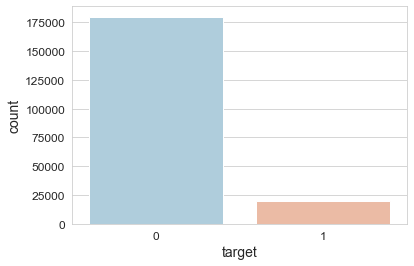

In [12]:
# use seaborn
sns.set_style('whitegrid')
sns.countplot(x='target',data=train,palette='RdBu_r')

90% of the target has value of 0.

<h3> Prepare the Data for Machine Learning Algorithms </h3>

### Modelling

Thw following models are updated from these beutiful Kaggle karnels
https://www.kaggle.com/bogorodvo/starter-code-saving-and-loading-lgb-xgb-cb
https://www.kaggle.com/jesucristo/30-lines-starter-solution-fast

<h5> Different Models </h5>

<h3> LGBMClassifier </h3>

In [13]:
def fit_lgb(X_fit, y_fit, X_val, y_val, counter, lgb_path, name):
    
    model = lgb.LGBMClassifier(max_depth=-1,
                               n_estimators=500,
                               learning_rate=0.02,
                               colsample_bytree=0.3,
                               num_leaves=2,
                               metric='auc',
                               objective='binary', 
                               n_jobs=-1)
     
    model.fit(X_fit, y_fit, 
              eval_set=[(X_val, y_val)],
              verbose=0, 
              early_stopping_rounds=100)
                  
    cv_val = model.predict_proba(X_val)[:,1]
    
    #Save LightGBM Model
    save_to = '{}{}_fold{}.txt'.format(lgb_path, name, counter+1)
    model.booster_.save_model(save_to)
    
    return cv_val

<h3> XGBClassifier </h3>

In [14]:
def fit_xgb(X_fit, y_fit, X_val, y_val, counter, xgb_path, name):
    
    model = xgb.XGBClassifier(max_depth=2,
                              n_estimators=500,
                              colsample_bytree=0.3,
                              learning_rate=0.02,
                              objective='binary:logistic', 
                              n_jobs=-1)
     
    model.fit(X_fit, y_fit, 
              eval_set=[(X_val, y_val)], 
              verbose=0, 
              early_stopping_rounds=100)
              
    cv_val = model.predict_proba(X_val)[:,1]
    
    #Save XGBoost Model
    save_to = '{}{}_fold{}.dat'.format(xgb_path, name, counter+1)
    pickle.dump(model, open(save_to, "wb"))
    
    return cv_val

<h3> CatBoostClassifier </h3>

In [15]:
def fit_cb(X_fit, y_fit, X_val, y_val, counter, cb_path, name):
    
    model = cb.CatBoostClassifier(iterations=500,
                                  max_depth=2,
                                  learning_rate=0.02,
                                  colsample_bylevel=0.03,
                                  objective="Logloss")
                                  
    model.fit(X_fit, y_fit, 
              eval_set=[(X_val, y_val)], 
              verbose=0, early_stopping_rounds=100)
              
    cv_val = model.predict_proba(X_val)[:,1]
    
    #Save Catboost Model          
    save_to = "{}{}_fold{}.mlmodel".format(cb_path, name, counter+1)
    model.save_model(save_to, format="coreml", 
                     export_parameters={'prediction_type': 'probability'})
                     
    return cv_val

<h5> Training the Data </h5>

In [16]:
def train_stage( lgb_path, xgb_path, cb_path):
    
    print('Load Train Data.')
    df = train
    print('\nShape of Train Data: {}'.format(df.shape))
    
    y_df = np.array(df['target'])                        
    df_ids = np.array(df.index)                     
    df.drop(['ID_code', 'target'], axis=1, inplace=True)
    
    lgb_cv_result = np.zeros(df.shape[0])
    xgb_cv_result = np.zeros(df.shape[0])
    cb_cv_result  = np.zeros(df.shape[0])
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    skf.get_n_splits(df_ids, y_df)
    
    print('\nModel Fitting...')
    for counter, ids in enumerate(skf.split(df_ids, y_df)):
        print('\nFold {}'.format(counter+1))
        X_fit, y_fit = df.values[ids[0]], y_df[ids[0]]
        X_val, y_val = df.values[ids[1]], y_df[ids[1]]
    
        print('LigthGBM')
        lgb_cv_result[ids[1]] += fit_lgb(X_fit, y_fit, X_val, y_val, counter, lgb_path, name='lgb')
        print('XGBoost')
        xgb_cv_result[ids[1]] += fit_xgb(X_fit, y_fit, X_val, y_val, counter, xgb_path, name='xgb')
        print('CatBoost')
        cb_cv_result[ids[1]]  += fit_cb(X_fit,  y_fit, X_val, y_val, counter, cb_path,  name='cb')
        
        del X_fit, X_val, y_fit, y_val
        gc.collect()
    
    auc_lgb  = round(roc_auc_score(y_df, lgb_cv_result),4)
    auc_xgb  = round(roc_auc_score(y_df, xgb_cv_result),4)
    auc_cb   = round(roc_auc_score(y_df, cb_cv_result), 4)
    auc_mean = round(roc_auc_score(y_df, (lgb_cv_result+xgb_cv_result+cb_cv_result)/3), 4)
    auc_mean_lgb_cb = round(roc_auc_score(y_df, (lgb_cv_result+cb_cv_result)/2), 4)
    print('\nLightGBM VAL AUC: {}'.format(auc_lgb))
    print('XGBoost  VAL AUC: {}'.format(auc_xgb))
    print('Catboost VAL AUC: {}'.format(auc_cb))
    print('Mean Catboost+LightGBM VAL AUC: {}'.format(auc_mean_lgb_cb))
    print('Mean XGBoost+Catboost+LightGBM, VAL AUC: {}\n'.format(auc_mean))
    
    return 0

</h5> Predictction </h5>

In [17]:
def prediction_stage( lgb_path, xgb_path, cb_path):
    
    print('Load Test Data.')
    df = test
    print('\nShape of Test Data: {}'.format(df.shape))
    
    df.drop(['ID_code'], axis=1, inplace=True)
    
    lgb_models = sorted(os.listdir(lgb_path))
    xgb_models = sorted(os.listdir(xgb_path))
    cb_models  = sorted(os.listdir(cb_path))
    
    lgb_result = np.zeros(df.shape[0])
    xgb_result = np.zeros(df.shape[0])
    cb_result  = np.zeros(df.shape[0])
    
    print('\nMake predictions...\n')
    
    print('With LightGBM...')
    for m_name in lgb_models:
        #Load LightGBM Model
        model = lgb.Booster(model_file='{}{}'.format(lgb_path, m_name))
        lgb_result += model.predict(df.values)
     
    print('With XGBoost...')    
    for m_name in xgb_models:
        #Load Catboost Model
        model = pickle.load(open('{}{}'.format(xgb_path, m_name), "rb"))
        xgb_result += model.predict_proba(df.values)[:,1]
    
    print('With CatBoost...')        
    for m_name in cb_models:
        #Load Catboost Model
        model = cb.CatBoostClassifier()
        model = model.load_model('{}{}'.format(cb_path, m_name), format = 'coreml')
        cb_result += model.predict(df.values, prediction_type='Probability')[:,1]
    
    lgb_result /= len(lgb_models)
    xgb_result /= len(xgb_models)
    cb_result  /= len(cb_models)
    

    submission['target'] = (lgb_result+xgb_result+cb_result)/3
    submission.to_csv('xgb_lgb_cb_starter_submission.csv', index=False)
    submission['target'] = (lgb_result+cb_result)/2
    submission.to_csv('lgb_cb_starter_submission.csv', index=False)
    submission['target'] = xgb_result
    submission.to_csv('xgb_starter_submission.csv', index=False)
    submission['target'] = lgb_result
    submission.to_csv('lgb_starter_submission.csv', index=False)
    submission['target'] = cb_result
    submission.to_csv('cb_starter_submission.csv', index=False)
    
    return 0
    
    
if __name__ == '__main__':
    
#     train_path = '../input/train.csv'
#     test_path  = '../input/test.csv'
    
    lgb_path = './lgb_models_stack/'
    xgb_path = './xgb_models_stack/'
    cb_path  = './cb_models_stack/'

    #Create dir for models
    os.mkdir(lgb_path)
    os.mkdir(xgb_path)
    os.mkdir(cb_path)

    print('Train Stage.\n')
    train_stage(lgb_path='./lgb_models_stack/', xgb_path='./xgb_models_stack/', cb_path='./cb_models_stack/')
    
    print('Prediction Stage.\n')
    prediction_stage(lgb_path, xgb_path, cb_path)
    
    print('\nDone.')

Train Stage.

Load Train Data.

Shape of Train Data: (200000, 202)

Model Fitting...

Fold 1
LigthGBM
XGBoost
CatBoost

Fold 2
LigthGBM
XGBoost
CatBoost

Fold 3
LigthGBM
XGBoost
CatBoost

LightGBM VAL AUC: 0.7901
XGBoost  VAL AUC: 0.55
Catboost VAL AUC: 0.837
Mean Catboost+LightGBM VAL AUC: 0.8191
Mean XGBoost+Catboost+LightGBM, VAL AUC: 0.819

Prediction Stage.

Load Test Data.

Shape of Test Data: (200000, 201)

Make predictions...

With LightGBM...
With XGBoost...
With CatBoost...

Done.


A better accuracy is obtained using only few lines of code with LightGBM

In [22]:
train = pd.read_csv (r'D:\Desktop\Kaggle Competitions\santander-customer-transaction-prediction\train.csv')

In [27]:
features= [x for x in train.columns if x not in ['ID_code', 'target']]

In [29]:
target = train['target']
param = {
    'bagging_freq': 5,          
    'bagging_fraction': 0.38,   'boost_from_average':'false',   
    'boost': 'gbdt',             'feature_fraction': 0.04,     'learning_rate': 0.0085,
    'max_depth': -1,             'metric':'auc',                'min_data_in_leaf': 80,     'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,            'num_threads': 8,              'tree_learner': 'serial',   'objective': 'binary',
    'reg_alpha': 0.1302650970728192, 'reg_lambda': 0.3603427518866501,'verbosity': 1
}
folds = StratifiedKFold(n_splits=12, shuffle=False, random_state=99999)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 1000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 2000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
sub = pd.DataFrame({"ID_code": test.ID_code.values})
sub["target"] = predictions
sub.to_csv("submission.csv", index=False)

Fold 0
Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[997]	training's auc: 0.900408	valid_1's auc: 0.881818
Fold 1
Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[997]	training's auc: 0.900367	valid_1's auc: 0.885342
Fold 2
Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.901211	valid_1's auc: 0.874796
Fold 3
Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[997]	training's auc: 0.899707	valid_1's auc: 0.888583
Fold 4
Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[997]	training's auc: 0.900525	valid_1's auc: 0.877114
Fold 5
Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[997]	training's

AttributeError: 'DataFrame' object has no attribute 'ID_code'